In [3]:
import json
import random

import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset,Subset

import matplotlib.pyplot as plt
import pandas as pd

from tqdm.notebook import tqdm

In [4]:

summary = pd.read_csv('genome_data/data/data_summary.tsv', delimiter='\t')
summary_filtered = summary[summary['Assembly Accession'].str.contains('GCF')]

In [5]:
BASES_DICT = {s: i for i, s in enumerate("ACGTN")}

def oneHotEncode(sequence:str) -> torch.Tensor:
    L = len(sequence)
    tens = torch.zeros(5, L)

    for i, s in enumerate(sequence.upper()):
        base = BASES_DICT.get(s)
        tens[base,i]= 1.0
    
    return tens

In [6]:
class DNAReadDataset(Dataset):

    ## tells class what to do when created
    def __init__(self, data_path):
        self.data = []

        with open(data_path, 'r') as f:
            for line in f:
                json_object = json.loads(line)
                self.data.append(json_object)
           
        all_species = sorted(set(d['species_id'] for d in self.data))
        self.species = {s: i for i, s in enumerate(all_species)}

    ## how many exmapels we have in a dataset once we get it
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        record = self.data[idx]
        x = oneHotEncode(record['sequence'])
        y = torch.tensor(self.species[record['species_id']])

        return x, y

    @property
    def classes(self):
        return self.species
    
dataset = DNAReadDataset(data_path='genome_data/generated_reads.jsonl')
dataloader = DataLoader(dataset,batch_size=128, shuffle=True)


In [ ]:
seq, spec = dataset[1800]
seq.shape
for seq, spec in dataset:
    break

In [89]:
# batchsize = # examples we pull each time we iterate thorugh, shuffle = each time is random pulling (only need when trainig)
dataloader = DataLoader(dataset,batch_size=128, shuffle=True)

In [90]:
for seqs, specs in dataloader:
    break

seqs.shape, specs.shape

(torch.Size([128, 5, 300]), torch.Size([128]))

In [ ]:
# since we put shuffle, and know labels were in order previously, we now has tensor of random order of labels
specs

tensor([4, 8, 5, 1, 4, 5, 1, 9, 1, 1, 7, 9, 7, 8, 9, 6, 2, 2, 0, 3, 5, 1, 1, 1,
        1, 6, 4, 3, 8, 5, 4, 3, 7, 7, 1, 6, 9, 2, 8, 4, 3, 8, 7, 1, 6, 2, 4, 6,
        0, 8, 4, 9, 1, 7, 2, 5, 7, 2, 2, 5, 4, 5, 0, 8, 7, 2, 3, 7, 5, 1, 5, 4,
        1, 4, 3, 5, 0, 6, 6, 2, 3, 2, 4, 6, 6, 4, 0, 0, 1, 1, 7, 4, 2, 8, 7, 2,
        0, 0, 1, 2, 3, 7, 3, 3, 5, 8, 6, 1, 7, 8, 7, 6, 5, 6, 6, 4, 6, 8, 4, 3,
        3, 8, 5, 8, 8, 8, 0, 9])

### Pytorch Model

In [18]:
### First try linear
class LinearClassifier(nn.Module):
    def __init__(self, seq_len=300, num_classes=10):
        super().__init__()
        # DECISION 1: Input size
        # - We have 5 channels × 300 length = 1500 features
        # - Need to flatten: (batch, 5, 300) → (batch, 1500)
        
        # DECISION 2: Hidden layer size
        # Rule of thumb: Start with sqrt(input_size × output_size)
        # √(1500 × 10) ≈ 122, round to 128 (powers of 2)
        
        # DECISION 3: Dropout rate
        # used for regularization to prevent overfitting (randomly drops out 
        # fraction of neurons in layer during each for/backward pass)
        # Start with 0.3 (30% dropout) - common default
        # Too high (>0.5) → underfitting
        # Too low (<0.1) → overfitting

        self.fc = nn.Sequential(
            nn.Linear(5 * seq_len, 128),  # 1500 → 128
            nn.ReLU(),                     # Non-linearity
            nn.Dropout(0.3),               # Regularization
            nn.Linear(128, num_classes)    # 128 → 10
        )

    def forward(self, x):
        x = x.flatten(start_dim=1)
        return self.fc(x)
        # reshape to flatten sequence dimension
        


In [124]:
## add a batch dimension
output = model(seq.unsqueeze(0))

In [ ]:
output.shape # torch.Size([batch_size, numclas])
# will have probabilities for each class

torch.Size([1, 10])

In [7]:
dataset = DNAReadDataset('genome_data/generated_reads.jsonl')

print(f"Total samples: {len(dataset)}")
print(f"Sequence length: {len(dataset.data[0]['sequence'])}")
print(f"Number of species: {len(dataset.classes)}")

Total samples: 20000
Sequence length: 300
Number of species: 10


### Training Loop
- feed data into model recursively and then apply loss function to outputs 
- how the model learns
- does this in batches (step: one batch of data as defined in our dataloader)
- then call one epoch: a run thru all the batches  in one training dataset

- two thing to select:
    - optimizer: adam is best place to start
    - loss function: what model will optimize for


In [19]:
def split_dataset(dataset, val_frac=0.2, seed=42):
    idxs = list(range(len(dataset)))
    random.Random(seed).shuffle(idxs)
    cut = int(len(idxs) * (1 - val_frac))
    train_idx, val_idx = idxs[:cut], idxs[cut:]
    return Subset(dataset, train_idx), Subset(dataset, val_idx)

dataset = DNAReadDataset('genome_data/generated_reads.jsonl')
train_dataset, testval_dataset = split_dataset(dataset)
test_dataset, val_dataset = split_dataset(testval_dataset, val_frac=0.5)


train_loader = DataLoader(train_dataset,batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset,batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset,batch_size=128, shuffle=False)


model = LinearClassifier()
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)
model.to(device)

# loss function 
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


mps


In [ ]:
spec = spec.unsqueeze(0)
criterion(output, spec)

In [20]:
num_epochs = 30
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    #set model to train
    model.train()
    running_loss = 0.0
    for seq, spec in train_loader:
        seq, spec = seq.to(device), spec.to(device)
        optimizer.zero_grad()
        outputs = model(seq.float())
        loss = criterion(outputs, spec)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * seq.size(0)
    train_loss = running_loss/len(train_loader.dataset)
    train_losses.append(train_loss)

    # validation
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        #for seq, spec in tqdm(val_loader, desc="Validation loop"):
        for seq, spec in val_loader:
            seq, spec = seq.to(device), spec.to(device)
            outputs = model(seq.float())
            loss = criterion(outputs, spec)
            running_loss += loss.item() * seq.size(0)
    val_loss = running_loss/len(val_loader.dataset)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss} - Valid loss: {val_loss}") 


Epoch 1/30 - Train loss: 1.8150678968429566 - Valid loss: 1.6484404125213623
Epoch 2/30 - Train loss: 1.6161179485321044 - Valid loss: 1.6471455602645875
Epoch 3/30 - Train loss: 1.555106803894043 - Valid loss: 1.64285205078125
Epoch 4/30 - Train loss: 1.502368727684021 - Valid loss: 1.6606377325057984
Epoch 5/30 - Train loss: 1.4508179931640626 - Valid loss: 1.6892008075714111
Epoch 6/30 - Train loss: 1.3942176208496093 - Valid loss: 1.7038995122909546
Epoch 7/30 - Train loss: 1.3358833150863647 - Valid loss: 1.7218245916366577
Epoch 8/30 - Train loss: 1.2648245401382445 - Valid loss: 1.7436533050537109
Epoch 9/30 - Train loss: 1.205290738105774 - Valid loss: 1.7658107900619506
Epoch 10/30 - Train loss: 1.1446383781433105 - Valid loss: 1.8028907079696654
Epoch 11/30 - Train loss: 1.0800209860801697 - Valid loss: 1.8496980304718018
Epoch 12/30 - Train loss: 1.0141772871017456 - Valid loss: 1.857813892364502
Epoch 13/30 - Train loss: 0.9478043208122253 - Valid loss: 1.9032377090454102
E

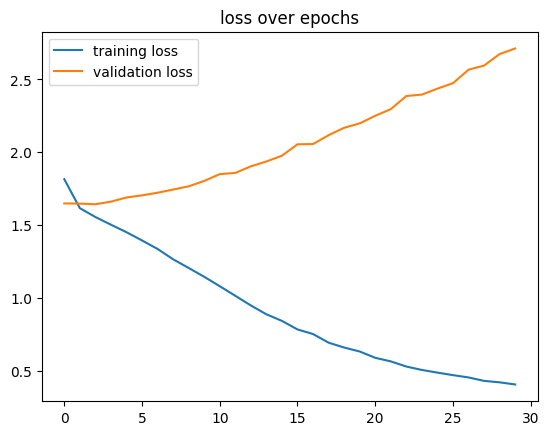

In [21]:
plt.plot(train_losses, label="training loss")
plt.plot(val_losses, label="validation loss")
plt.legend()
plt.title("loss over epochs")
plt.show()

In [26]:
### Decrease regularization
class LinearClassifier(nn.Module):
    def __init__(self, seq_len=300, num_classes=10):
        super().__init__()

        self.fc = nn.Sequential(
            nn.Linear(5 * seq_len, 128),  # 1500 → 128
            nn.ReLU(),                     # Non-linearity
            nn.Dropout(0.5),               # Regularization
            nn.Linear(128, num_classes)    # 128 → 10
        )

    def forward(self, x):
        x = x.flatten(start_dim=1)
        return self.fc(x)


In [27]:
model = LinearClassifier(seq_len=300, num_classes=10)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  

In [28]:
# Training with early stopping
num_epochs = 30
train_losses, val_losses = [], []
train_accs, val_accs = [], []

best_val_loss = float('inf')
patience = 5
patience_counter = 0

for epoch in range(num_epochs):
    # Training
    model.train()
    running_loss = 0.0
    train_correct = 0
    train_total = 0
    
    for seq, spec in train_loader:
        seq, spec = seq.to(device), spec.to(device)
        
        optimizer.zero_grad()
        outputs = model(seq.float())
        loss = criterion(outputs, spec)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * seq.size(0)
        _, predicted = outputs.max(1)
        train_total += spec.size(0)
        train_correct += predicted.eq(spec).sum().item()
    
    train_loss = running_loss / len(train_loader.dataset)
    train_acc = 100. * train_correct / train_total
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    # Validation
    model.eval()
    running_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for seq, spec in val_loader:
            seq, spec = seq.to(device), spec.to(device)
            outputs = model(seq.float())
            loss = criterion(outputs, spec)
            
            running_loss += loss.item() * seq.size(0)
            _, predicted = outputs.max(1)
            val_total += spec.size(0)
            val_correct += predicted.eq(spec).sum().item()
    
    val_loss = running_loss / len(val_loader.dataset)
    val_acc = 100. * val_correct / val_total
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    print(f"Epoch {epoch+1:2d}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f} Acc: {train_acc:5.2f}% | "
          f"Val Loss: {val_loss:.4f} Acc: {val_acc:5.2f}%")
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_linear_model.pt')
        print("  → Saved best model")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"\nEarly stopping at epoch {epoch+1}")
            break

# Load best model
model.load_state_dict(torch.load('best_linear_model.pt'))


Epoch  1/30 | Train Loss: 1.8755 Acc: 25.57% | Val Loss: 1.6629 Acc: 34.40%
  → Saved best model
Epoch  2/30 | Train Loss: 1.6542 Acc: 33.99% | Val Loss: 1.6290 Acc: 33.50%
  → Saved best model
Epoch  3/30 | Train Loss: 1.6012 Acc: 37.20% | Val Loss: 1.6341 Acc: 33.45%
Epoch  4/30 | Train Loss: 1.5574 Acc: 39.29% | Val Loss: 1.6429 Acc: 34.80%
Epoch  5/30 | Train Loss: 1.5251 Acc: 41.38% | Val Loss: 1.6581 Acc: 32.65%
Epoch  6/30 | Train Loss: 1.4917 Acc: 42.38% | Val Loss: 1.6584 Acc: 33.20%
Epoch  7/30 | Train Loss: 1.4556 Acc: 44.41% | Val Loss: 1.6717 Acc: 32.70%

Early stopping at epoch 7


Epoch  1/30 | Train Loss: 1.8755 Acc: 25.57% | Val Loss: 1.6629 Acc: 34.40%
  → Saved best model
Epoch  2/30 | Train Loss: 1.6542 Acc: 33.99% | Val Loss: 1.6290 Acc: 33.50%
  → Saved best model
Epoch  3/30 | Train Loss: 1.6012 Acc: 37.20% | Val Loss: 1.6341 Acc: 33.45%
Epoch  4/30 | Train Loss: 1.5574 Acc: 39.29% | Val Loss: 1.6429 Acc: 34.80%
Epoch  5/30 | Train Loss: 1.5251 Acc: 41.38% | Val Loss: 1.6581 Acc: 32.65%
Epoch  6/30 | Train Loss: 1.4917 Acc: 42.38% | Val Loss: 1.6584 Acc: 33.20%
Epoch  7/30 | Train Loss: 1.4556 Acc: 44.41% | Val Loss: 1.6717 Acc: 32.70%

Early stopping at epoch 7


<All keys matched successfully>

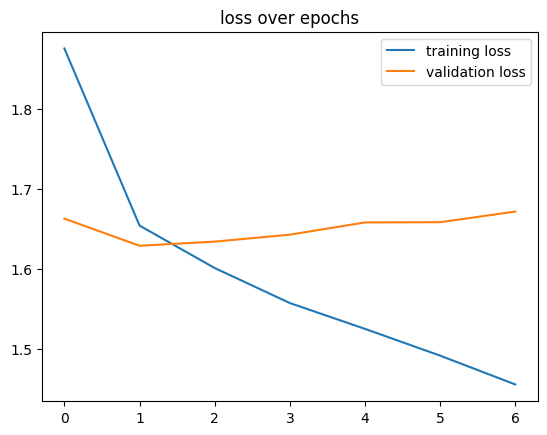

In [29]:
plt.plot(train_losses, label="training loss")
plt.plot(val_losses, label="validation loss")
plt.legend()
plt.title("loss over epochs")
plt.show()

In [30]:
## TEST
def test_model(model, test_loader, device):
    model.eval()
    
    test_loss = 0.0
    test_correct = 0
    test_total = 0
    
    all_preds = []
    all_labels = []
    
    criterion = nn.CrossEntropyLoss()
    
    with torch.no_grad():
        for seq, spec in test_loader:
            seq, spec = seq.to(device), spec.to(device)
            
            outputs = model(seq.float())
            loss = criterion(outputs, spec)
            
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            test_total += spec.size(0)
            test_correct += predicted.eq(spec).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(spec.cpu().numpy())
    
    test_loss /= len(test_loader)
    test_acc = 100. * test_correct / test_total
    
    print("="*60)
    print("TEST SET RESULTS")
    print("="*60)
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_acc:.2f}%")
    print()
    
    return test_loss, test_acc, all_preds, all_labels


test_loss, test_acc, preds, labels = test_model(model, test_loader, device)

print(f"\nLINEAR BASELINE: {test_acc:.2f}% test accuracy")

TEST SET RESULTS
Test Loss: 1.6433
Test Accuracy: 32.95%


LINEAR BASELINE: 32.95% test accuracy


In [31]:
class SimpleCNN(nn.Module):
    def __init__(self, seq_len=300, num_classes=10):
        super().__init__()
        
        self.features = nn.Sequential(
            # Conv layer
            nn.Conv1d(5, 64, kernel_size=8, padding=4),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Dropout(0.3),
            
            # Second conv layer
            nn.Conv1d(64, 128, kernel_size=8, padding=4),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(1),  # Global pooling
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(64, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

### TRAINING 

# Create model
cnn_model = SimpleCNN(seq_len=300, num_classes=10)
cnn_model = cnn_model.to(device)

cnn_optimizer = optim.Adam(cnn_model.parameters(), lr=0.001, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

num_epochs = 20  # Quick training
cnn_train_losses, cnn_val_losses = [], []
cnn_train_accs, cnn_val_accs = [], []

best_val_loss = float('inf')
patience = 5
patience_counter = 0

print("Training CNN...")

for epoch in range(num_epochs):
    # Training
    cnn_model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    for seq, spec in train_loader:
        seq, spec = seq.to(device), spec.to(device)
        
        cnn_optimizer.zero_grad()
        outputs = cnn_model(seq.float())
        loss = criterion(outputs, spec)
        loss.backward()
        cnn_optimizer.step()
        
        train_loss += loss.item() * seq.size(0)
        _, predicted = outputs.max(1)
        train_total += spec.size(0)
        train_correct += predicted.eq(spec).sum().item()
    
    train_loss = train_loss / len(train_loader.dataset)
    train_acc = 100. * train_correct / train_total
    cnn_train_losses.append(train_loss)
    cnn_train_accs.append(train_acc)
    
    # Validation
    cnn_model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for seq, spec in val_loader:
            seq, spec = seq.to(device), spec.to(device)
            outputs = cnn_model(seq.float())
            loss = criterion(outputs, spec)
            
            val_loss += loss.item() * seq.size(0)
            _, predicted = outputs.max(1)
            val_total += spec.size(0)
            val_correct += predicted.eq(spec).sum().item()
    
    val_loss = val_loss / len(val_loader.dataset)
    val_acc = 100. * val_correct / val_total
    cnn_val_losses.append(val_loss)
    cnn_val_accs.append(val_acc)
    
    print(f"Epoch {epoch+1:2d}/{num_epochs}"
          f"Train Loss: {train_loss:.4f} Acc: {train_acc:5.2f}%"
          f"Val Loss: {val_loss:.4f} Acc: {val_acc:5.2f}%")
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(cnn_model.state_dict(), 'best_cnn_model.pt')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"\nEarly stopping at epoch {epoch+1}")
            break

# Load best model
cnn_model.load_state_dict(torch.load('best_cnn_model.pt'))

# Test CNN
print("\n" + "="*60)
print("Testing CNN...")
cnn_test_loss, cnn_test_acc, cnn_preds, cnn_labels = test_model(cnn_model, test_loader, device)




Training CNN...
Epoch  1/20Train Loss: 1.9610 Acc: 23.77%Val Loss: 1.6774 Acc: 40.05%
Epoch  2/20Train Loss: 1.6606 Acc: 33.81%Val Loss: 1.5026 Acc: 45.65%
Epoch  3/20Train Loss: 1.5212 Acc: 39.65%Val Loss: 1.3408 Acc: 50.60%
Epoch  4/20Train Loss: 1.4112 Acc: 44.17%Val Loss: 1.2568 Acc: 52.65%
Epoch  5/20Train Loss: 1.3387 Acc: 47.71%Val Loss: 1.1789 Acc: 57.20%
Epoch  6/20Train Loss: 1.2979 Acc: 49.14%Val Loss: 1.1634 Acc: 58.00%
Epoch  7/20Train Loss: 1.2643 Acc: 50.44%Val Loss: 1.1114 Acc: 59.10%
Epoch  8/20Train Loss: 1.2113 Acc: 51.89%Val Loss: 1.0914 Acc: 60.30%
Epoch  9/20Train Loss: 1.1795 Acc: 53.46%Val Loss: 1.0345 Acc: 63.25%
Epoch 10/20Train Loss: 1.1547 Acc: 54.19%Val Loss: 1.0190 Acc: 63.90%
Epoch 11/20Train Loss: 1.1267 Acc: 55.90%Val Loss: 0.9839 Acc: 64.25%
Epoch 12/20Train Loss: 1.1037 Acc: 56.33%Val Loss: 0.9731 Acc: 63.70%
Epoch 13/20Train Loss: 1.0743 Acc: 57.83%Val Loss: 0.9554 Acc: 65.50%
Epoch 14/20Train Loss: 1.0621 Acc: 58.16%Val Loss: 0.9655 Acc: 63.05%
Epoc

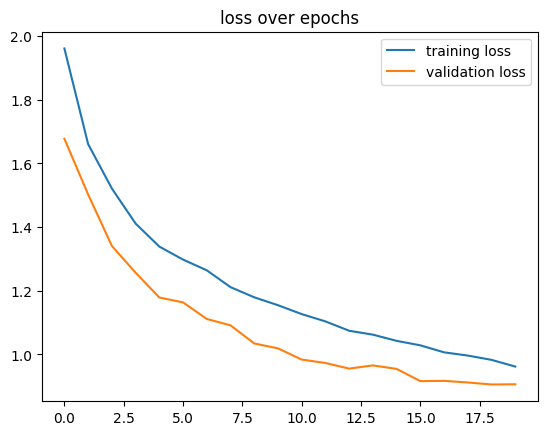

In [32]:
plt.plot(cnn_train_losses, label="training loss")
plt.plot(cnn_val_losses, label="validation loss")
plt.legend()
plt.title("loss over epochs")
plt.show()

### Compare Baseline vs CNN plots

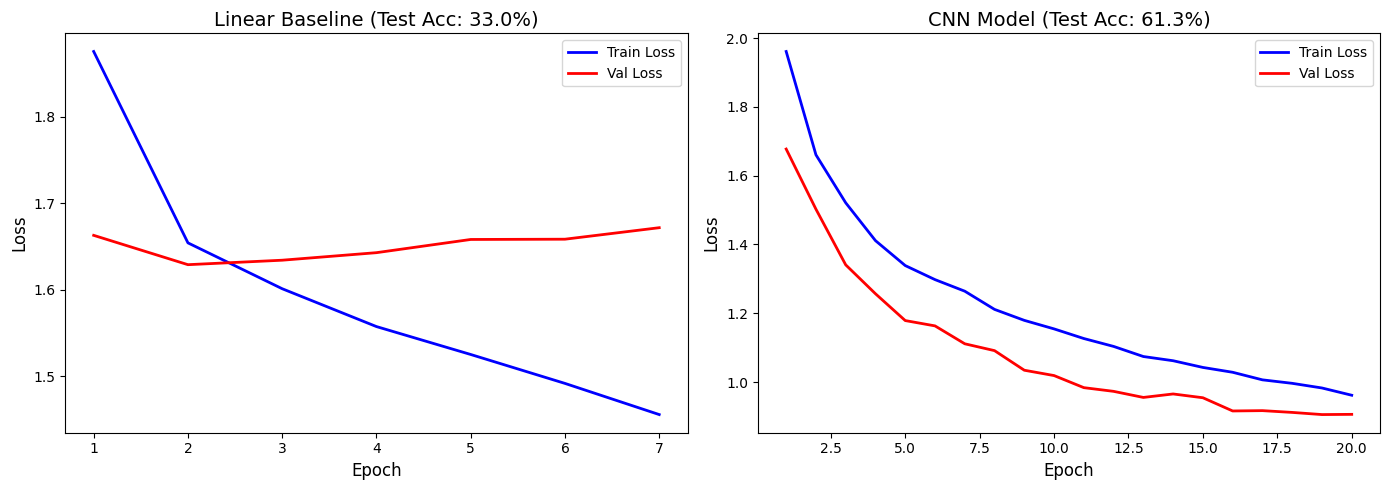

In [72]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Linear plot
epochs_linear = range(1, len(train_losses) + 1)
ax1.plot(epochs_linear, train_losses, 'b-', label='Train Loss', linewidth=2)
ax1.plot(epochs_linear, val_losses, 'r-', label='Val Loss', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title(f'Linear Baseline (Test Acc: {test_acc:.1f}%)', fontsize=14)
ax1.legend()

# CNN plot
epochs_cnn = range(1, len(cnn_train_losses) + 1)
ax2.plot(epochs_cnn, cnn_train_losses, 'b-', label='Train Loss', linewidth=2)
ax2.plot(epochs_cnn, cnn_val_losses, 'r-', label='Val Loss', linewidth=2)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.set_title(f'CNN Model (Test Acc: {cnn_test_acc:.1f}%)', fontsize=14)
ax2.legend()

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300)
plt.show()


## Per-Class Metrics & Confusion Matrix Analysis

In [73]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import numpy as np
import seaborn as sns

# Get species names for better display
species_names = list(summary_filtered['Assembly Accession'].unique())
print(f"Number of species: {len(species_names)}\n")
print(f"Species accessions: {species_names}\n")

Number of species: 10

Species accessions: ['GCF_000006945.2', 'GCF_000009045.1', 'GCF_000195955.2', 'GCF_001457635.1', 'GCF_006094295.1', 'GCF_006094375.1', 'GCF_019048645.1', 'GCF_020099175.1', 'GCF_025998455.1', 'GCF_034478925.1']



In [74]:
def print_per_class_metrics(y_true, y_pred, model_name, species_names):
    """
    Print per-class precision, recall, and F1-score
    """
    print("="*80)
    print(f"{model_name} - PER-CLASS METRICS")
    print("="*80)
    
    # Calculate metrics
    precision, recall, f1, support = precision_recall_fscore_support(
        y_true, y_pred, average=None, zero_division=0
    )
    
    # Print header
    print(f"{'Species':<40} {'Precision':>10} {'Recall':>10} {'F1-Score':>10} {'Support':>10}")
    print("-"*80)
    
    # Print per-class metrics
    for i, species in enumerate(species_names):
        # Truncate long species names
        species_display = species[:37] + "..." if len(species) > 40 else species
        print(f"{species_display:<40} {precision[i]:>10.3f} {recall[i]:>10.3f} {f1[i]:>10.3f} {support[i]:>10}")
    
    print("-"*80)
    
    # Print averages
    macro_p, macro_r, macro_f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average='macro', zero_division=0
    )
    weighted_p, weighted_r, weighted_f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average='weighted', zero_division=0
    )
    
    print(f"{'Macro Average':<40} {macro_p:>10.3f} {macro_r:>10.3f} {macro_f1:>10.3f} {len(y_true):>10}")
    print(f"{'Weighted Average':<40} {weighted_p:>10.3f} {weighted_r:>10.3f} {weighted_f1:>10.3f} {len(y_true):>10}")
    print("="*80)
    print()
    
    return precision, recall, f1, support

In [75]:
def plot_confusion_matrix(y_true, y_pred, species_names, model_name):
    """
    Plot confusion matrix as a heatmap
    """
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Create figure
    plt.figure(figsize=(12, 10))
    
    # Plot heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=range(len(species_names)), 
                yticklabels=range(len(species_names)),
                cbar_kws={'label': 'Count'})
    
    plt.title(f'{model_name} - Confusion Matrix', fontsize=16, pad=20)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    
    return cm

### Linear Baseline Model Analysis

Per-class precision, recall, f1-score, and support. 

- **Precision**: Of all samples predicted as this species, what percentage were correct? (TP / (TP + FP))
  - High precision = few false positives
  
- **Recall**: Of all actual samples of this species, what percentage did we correctly identify? (TP / (TP + FN))
  - High recall = few false negatives
  
- **F1-Score**: Harmonic mean of precision and recall (2 × (Precision × Recall) / (Precision + Recall))
  
- **Support**: Number of actual samples of this species in the test set



In [ ]:
linear_precision, linear_recall, linear_f1, linear_support = print_per_class_metrics(
    labels, preds, "Linear Baseline", species_names
)

Linear Baseline - PER-CLASS METRICS
Species                                   Precision     Recall   F1-Score    Support
--------------------------------------------------------------------------------
GCF_000006945.2                               0.346      0.310      0.327        203
GCF_000009045.1                               0.226      0.368      0.280        223
GCF_000195955.2                               0.663      0.851      0.745        194
GCF_001457635.1                               0.154      0.034      0.055        178
GCF_006094295.1                               0.238      0.406      0.300        212
GCF_006094375.1                               0.320      0.598      0.416        169
GCF_019048645.1                               0.208      0.075      0.111        199
GCF_020099175.1                               0.380      0.383      0.382        206
GCF_025998455.1                               0.237      0.117      0.157        196
GCF_034478925.1                  

### CNN Model Analysis

Per-class precision, recall, f1-score, and support. 

In [61]:
cnn_precision, cnn_recall, cnn_f1, cnn_support = print_per_class_metrics(
    cnn_labels, cnn_preds, "CNN Model", species_names
)

CNN Model - PER-CLASS METRICS
Species                                   Precision     Recall   F1-Score    Support
--------------------------------------------------------------------------------
GCF_000006945.2                               0.647      0.596      0.621        203
GCF_000009045.1                               0.439      0.193      0.268        223
GCF_000195955.2                               0.881      0.954      0.916        194
GCF_001457635.1                               0.541      0.562      0.551        178
GCF_006094295.1                               0.537      0.585      0.560        212
GCF_006094375.1                               0.448      0.734      0.556        169
GCF_019048645.1                               0.556      0.397      0.463        199
GCF_020099175.1                               0.702      0.515      0.594        206
GCF_025998455.1                               0.929      0.934      0.931        196
GCF_034478925.1                        

## Results & Key Findings

This section highlights important insights from the classification task.

In [ ]:
# Calculate comparative metrics
print("="*80)
print("MODEL COMPARISON SUMMARY")
print("="*80)
print()

# Overall accuracy comparison
print(f"Linear Baseline Test Accuracy: {test_acc:.2f}%")
print(f"CNN Model Test Accuracy:       {cnn_test_acc:.2f}%")
print(f"Improvement:                   {cnn_test_acc - test_acc:+.2f}%")
print()

# Average metrics comparison
linear_macro_f1 = linear_f1.mean()
cnn_macro_f1 = cnn_f1.mean()

print(f"Linear Macro-Average F1:       {linear_macro_f1:.3f}")
print(f"CNN Macro-Average F1:          {cnn_macro_f1:.3f}")
print(f"Improvement:                   {cnn_macro_f1 - linear_macro_f1:+.3f}")
print()


MODEL COMPARISON SUMMARY

Linear Baseline Test Accuracy: 32.95%
CNN Model Test Accuracy:       61.30%
Improvement:                   +28.35%

Linear Macro-Average F1:       0.301
CNN Macro-Average F1:          0.605
Improvement:                   +0.305



### Key Observations

NN achieves 61.3% accuracy vs 33.0% for linear baseline - nearly 2x improvement. Macro F1-score improved from 0.30 to 0.61 which is a substantial in per-class performance. This demonstrates that convolutional layers successfully captured DNA sequence patterns that the linear baseline did not.
However, 61% accuracy indicates significant room for improvement through, which I can approach via:
- Deeper architectures (add more conv layers)
- Hyperparameter tuning (learning rate, kernel sizes, filters)
- Longer training (more epochs)?
